# Starbucks Capstone Challenge

<img src="https://www.merca2.es/wp-content/uploads/2020/04/starbucks-coffee-e1585725335618.jpg">

# **Table of Contents**
1. [Introduction](#intro)
1. [Business Understanding](#business)
    1. [Portfolio Dataset](#portfolio)
    1. [Profile Dataset](#profile)
    1. [Transcript Dataset](#transcript)
1. [Data Cleaning](#prepare)
    1. [Clean Nulls](#clean)
    1. [Became member on](#member)
    1. [Cleaning events](#events)
    1. [Value Transcript](#dict)
    1. [Categorize](#cate)
    1. [Merge datasets](#merge)
1. [Analisys Data](#EDA)
    1. [What event has been held most frequently?](#event)
    1. [Which offer is the most popular?](#offer)
    1. [What is the most frequent age of our customers?](#age)
    1. [What kind of offers are most used depending on the gender?](#gender)
    1. [What is the most frequent income range of customers?](#income)
1. [Model Data](#model)
    1. [Unbalanced](#umbalanced)
    1. [Models](#models)
        1. [RandomForestClassifier](#forest)
        1. [SVM](#svn)
        1. [KNN](#knn)
        1. [Logistic Regression](#logistic)
1. [Results](#summary)
1. [Conclusion](#conclusion)

## Introduction
<a id="intro"></a>

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Problem

My task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.  

In addition to this data analysis, I will develop a model to predict when a user will perform the event of completing an offer, this model would be quite useful since it would predict which people will complete an offer or not, thus avoiding sending offers to people who will not complete them.

### Solution

To solve this problem that I have proposed, I will have to carry out a great process of pre-processing, cleaning of the data and from the clean data I will be able to make statistics of these and to solve some questions that I will have.  
And finally I will make a binary predictive model (complete or not complete), to be able to predict when a user is going to make a complete offer. This will help us to know which customer completes their offers and who does not, to save us from sending offers to customers who do not complete them.

## Business Understanding
<a id="business"></a>

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

We will import the libraries and load the datasets in Json format.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio Dataset
<a id="portfolio"></a>

This dataset has the information of all the offers to be used and their description.

In [32]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [33]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


As can be seen, this dataset is composed of 10 rows and 6 columns and has no null values.

In [34]:
portfolio.describe(include="all")

,reward,channels,difficulty,duration,offer_type,id
count,10.000000,10,10.000000,10.000000,10,10
unique,NaN,4,NaN,NaN,3,10
top,NaN,"[web, email, mobile, social]",NaN,NaN,bogo,2298d6c36e964ae4a3e7e9706d1fb8c2
freq,NaN,4,NaN,NaN,4,1
mean,4.200000,NaN,7.700000,6.500000,NaN,NaN
std,3.583915,NaN,5.831905,2.321398,NaN,NaN
min,0.000000,NaN,0.000000,3.000000,NaN,NaN
25%,2.000000,NaN,5.000000,5.000000,NaN,NaN
50%,4.000000,NaN,8.500000,7.000000,NaN,NaN
75%,5.000000,NaN,10.000000,7.000000,NaN,NaN


* offer_type : the main type of offer is the bogo, with a frequency of 4 offers of this type, moreover we must know that there are only 3 types of offers ('bogo', 'informational', 'discount').
* difficulty : most of the dataset is made up of offers that must be spent over 8.5 dollars and their maximum value is 20.
* reward : Most of the rewards are between 4 and 5 dollars and their maximum value is 10.
* duration: The majority of the rewards are constituted by 7 dollars and its maximum value is 10.
* channels: the most frequent channels are the offers that are on the web, email, mobile, social.

### Profile Dataset
<a id="profile"></a>

This dataset has the information of all the clients and their description.

In [35]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [36]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [37]:
profile.isna().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

As can be seen, this dataset is composed of 17000 and 5 columns, and also contains null values in the gender and income variables, which represent 12.7% of the dataset, which coincides with the same number of null values.

In [38]:
profile.describe(include="all")

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,cefb3db55cf048d0bbbc0cb2a19b52cd,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


* age : The average age of the clients is set at 58 and their maximum is 118.
* gender: the most frequent gender is male, with a percentage of 49%, and we have 3 gender values (male, female and other)
* income : half of the clients have an income of 64000 and their maximum is 120000.

### Transcript Dataset
<a id="transcript"></a>

This dataset has the information of all Starbucks transactions as a function of time.

In [39]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [40]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


As can be seen, this dataset is composed of 306534 rows and 4 columns and has no null values.


## Data Cleaning
<a id="prepare"></a>

### Clean Nulls
<a id="clean"></a>
To begin with I will process the null data that was seen in the dataset profile and you have to choose between imputing these data or eliminating these null rows.

In [41]:
profile.isna().sum()/profile.shape[0]

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

As you can see we have 12.7% of the rows with null values, I am going to examine those null rows and see if it makes sense for the rest of the columns to preserve those null values by making imputations or directly eliminating them.

In [42]:
profile[profile["gender"].isna()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


The null values of the gender column coincide with the null values of the income column and also the values of the age column seem to be simulated since it has very large values, I will continue to make a boxplot of this column and see if these extreme values correspond with outliers.  
And if it corresponds with this, I will choose the option to eliminate the rows with null values, as this information will introduce noise into the statistics and the predictive model.

<AxesSubplot:xlabel='age'>

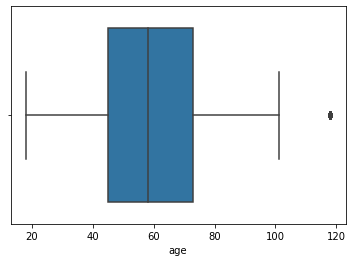

In [43]:
sns.boxplot(x=profile["age"])

As you can see in the boxplot, the rows that contain null values, are erroneous data since they are entering information with outliers, that is to say it is very rare that the age of the clients is 118, therefore by what I have mentioned previously I am going to eliminate all the rows with null values.

In [44]:
profile=profile.dropna()
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

### Became member on  
<a id="member"></a>

In this process it will be obtained how many days the client has been registered as a member, with reference to the last date of registration, this attribute should give enough information about whether the user follows the platform for a long time or is new.

In [45]:
#Get max date
last_inscription=max(profile["became_member_on"])
last_inscription=datetime.strptime(str(last_inscription), '%Y%m%d')
#diff date vs max date
profile["days_inscription"]=profile["became_member_on"].map(lambda x: (last_inscription-datetime.strptime(str(x), '%Y%m%d')).days)
profile

,gender,age,id,became_member_on,income,days_inscription
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,443
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,91
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,257
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,52
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,546
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,871


### Cleaning events
<a id="events"></a>

The column **event** of the dataset transcript has a word that is not necessary which is **offer**, therefore I will proceed with the elimination of that word.

In [46]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [47]:
transcript["event"]=transcript["event"].map(lambda x: x.replace("offer ",""))
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


### Value Transcript
<a id="dict"></a>

To finish I will proceed with cleaning the value column, which contains a dictionary with the ids of the offers, reward amount when completing an offer and the amount spent if no offer has been used.  
To do this I will take all these values and separate them one in each column i.e. I will separate the value column into 3 different columns: reward , offer and amount.

In [48]:
#Get the values of reward, if this key not exist return 0
def reward(a):
    if("reward" in a.keys()):
        return a["reward"]
    return 0

#Get the values of amount, if this key not exist return 0
def amount(a):
    if("amount" in a.keys()):
        return a["amount"]
    return 0

#Get the values of offer_id, if this key not exist return 0
def offer_id(a):
    if("offer id" in a.keys()):
        return a["offer id"]
    elif("offer_id" in a.keys()):
        return a["offer_id"]
    return 0


transcript["offer"]=transcript["value"].map(offer_id)
transcript["reward"]=transcript["value"].map(reward)
transcript["amount"]=transcript["value"].map(amount)
transcript=transcript.drop(['value'], axis=1)
transcript

,person,event,time,offer,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.00
1,a03223e636434f42ac4c3df47e8bac43,received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.00
2,e2127556f4f64592b11af22de27a7932,received,0,2906b810c7d4411798c6938adc9daaa5,0,0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0.00
4,68617ca6246f4fbc85e91a2a49552598,received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0.00
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,0,0,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,0,0,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,0,0,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,0,0,3.53


### Categorize  
<a id="cate"></a>

I am going to categorize two columns of the dataset profile, which are Age and Income, since it has a great variability and we could group these values in a few categories.  
* Age : Young (18,22) , Adult (22,60) and Elderly (60,max).  
* Income: Low, Medium, High. The values of this category will be divided into three categories.

In [49]:
#Category age and income
profile['age']=pd.cut(profile['age'], bins=[0, 22, 60, 200],labels=['Young', 'Adult', 'Elderly'])
profile['income']=pd.cut(profile['income'], bins=3,labels=['Low','Average','High'])
profile

,gender,age,id,became_member_on,income,days_inscription
1,F,Adult,0610b486422d4921ae7d2bf64640c50b,20170715,High,376
3,F,Elderly,78afa995795e4d85b5d9ceeca43f5fef,20170509,High,443
5,M,Elderly,e2127556f4f64592b11af22de27a7932,20180426,Average,91
8,M,Elderly,389bc3fa690240e798340f5a15918d5c,20180209,Low,167
12,M,Adult,2eeac8d8feae4a8cad5a6af0499a211d,20171111,Low,257
...,...,...,...,...,...,...
16995,F,Adult,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,Low,52
16996,M,Elderly,2cb4f97358b841b9a9773a7aa05a9d77,20180713,Average,13
16997,M,Adult,01d26f638c274aa0b965d24cefe3183f,20170126,Average,546
16998,F,Elderly,9dc1421481194dcd9400aec7c9ae6366,20160307,Low,871


### Merge datasets
<a id="merge"></a>

Finally, a single dataset will now be created from the unification of all these datasets, which will be used to perform the statistics and later to make the predictive model.

In [50]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [51]:
transcript_df=transcript[["event","person","offer","reward","amount"]].copy()
profile_df=profile[["age","gender","id","income","days_inscription"]].copy()
portfolio_df=portfolio[["id","offer_type","duration","difficulty"]].copy()

In [52]:
#Merge datasets
df=pd.merge(transcript_df,profile_df, left_on=['person'], right_on=['id'], how='left').dropna()
values = {'offer_type': "None", 'duration': 0, 'difficulty': 0}
df=pd.merge(df,portfolio_df, left_on=['offer'], right_on=['id'], how='left').fillna(value=values)
df=df.drop(["person","offer","id_x","id_y","reward","amount"],axis=1)
df

,event,age,gender,income,days_inscription,offer_type,duration,difficulty
0,received,Elderly,F,High,443.0,bogo,7.0,5.0
1,received,Elderly,M,Average,91.0,discount,7.0,10.0
2,received,Elderly,M,Low,167.0,bogo,5.0,5.0
3,received,Adult,M,Low,257.0,informational,4.0,0.0
4,received,Elderly,F,Low,318.0,discount,10.0,20.0
...,...,...,...,...,...,...,...,...
272757,completed,Adult,F,Average,210.0,discount,10.0,10.0
272758,transaction,Elderly,M,Low,206.0,None,0.0,0.0
272759,transaction,Adult,M,Average,109.0,None,0.0,0.0
272760,transaction,Elderly,F,Low,1768.0,None,0.0,0.0


Combining the three previous datasets has resulted in this dataset:
* event 
* age
* gender
* income
* days_inscription
* offer_type
* duration
* difficulty

## Analisys Data
<a id="EDA"></a>

Now that the data has been pre-processed and unified into a dataset, a data analysis will be performed by answering the following questions:

### 1. What event has been held most frequently?
<a id="event"></a>

To answer this question, the percentage of each event that has occurred will be obtained and represented graphically.

In [53]:
#get porcentajes of events
total=df.shape[0]
porc_received=(df[df["event"]=="received"].shape[0]/total)*100
porc_completed=(df[df["event"]=="completed"].shape[0]/total)*100
porc_viewed=(df[df["event"]=="viewed"].shape[0]/total)*100
porc_transaction=(df[df["event"]=="transaction"].shape[0]/total)*100

<AxesSubplot:>

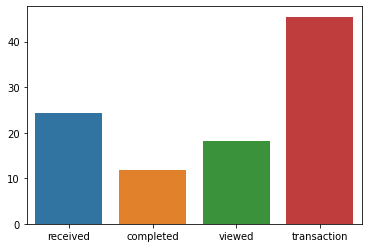

In [54]:
#plot the porcentajes of events
x=["received","completed","viewed","transaction"]
height=[porc_received,porc_completed,porc_viewed,porc_transaction]
sns.barplot(x, height)

As you can see, the most likely event is the transaction, that is, buying products without using any offer.  
And the events that are used in function of the offers is that 25% of the events are the reception of the offers but only 18% of the customers see those offers and finally 13% of the customers complete such offers.  
This means that only 13% of our sales come from the offers, which is a low percentage that should improve the sending of such offers to attract people who would complete them.

### 2. Which offer is the most popular?
<a id="offer"></a>

To do this we will examine all possible types of offers and then we will only keep all the offers that have as an event to complete to know which of these offers we have available are the most used by our customers.  
It should be remembered that the types of offers available are bogo, discount, informational and none (no use of offer)

Text(0, 0.5, 'Number of People')

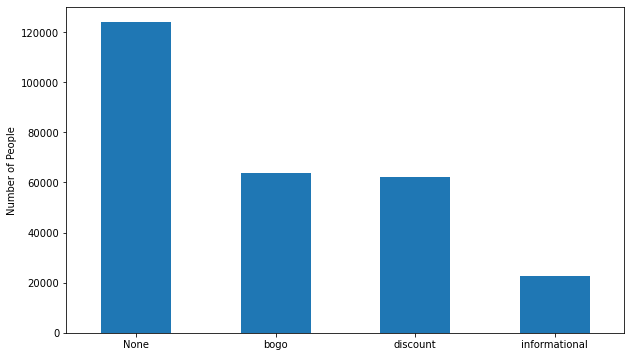

In [55]:
#plot the offer type
df.offer_type.value_counts().plot(kind='bar', rot=0, figsize=(10,6))
plt.ylabel('Number of People')

As you can see in the graph the most sent offer is bogo, along with the discount one and very behind is the informational one, but of course these are the most sent offers, but it is not the same as the ones that have been completed, so now you will see which offer is the most completed.

Text(0, 0.5, 'Number of People')

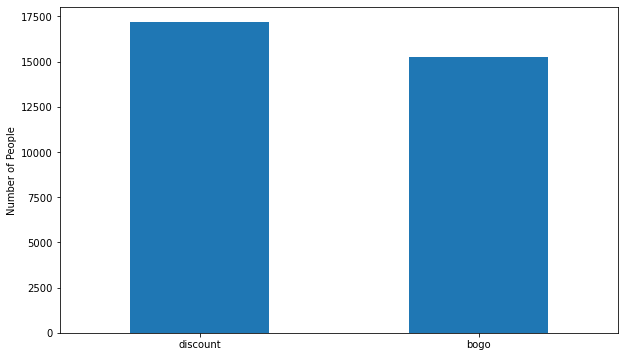

In [56]:
#plot the completed offer type
df[df["event"]=="completed"].offer_type.value_counts().plot(kind='bar', rot=0, figsize=(10,6))
plt.ylabel('Number of People')

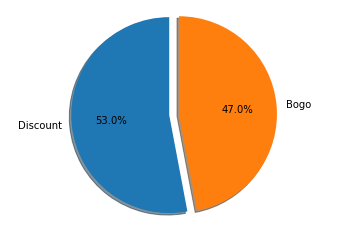

In [57]:
#plot pie chart the completed offer type
labels=['Discount','Bogo']
valores=df[df["event"]=="completed"].offer_type.value_counts()
values=[valores[0],  valores[1]]
explode=(0.1,0)

fig1, ax1 = plt.subplots()
ax1.pie(values,explode,labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

As you can see the most complete offer is the discount one although more Bogo offers are sent, although the difference between its use is 6% which is not much, so from this question you will not see any change in this.

### 3. What is the most frequent age of our customers?
<a id="age"></a>

We will now analyse the age of our most frequent clients.  
It should be remembered that the ages were divided into these categories:    
* Young (18,22) , Adult (22,60) and Elderly (60,max)  

Text(0, 0.5, 'Number of People')

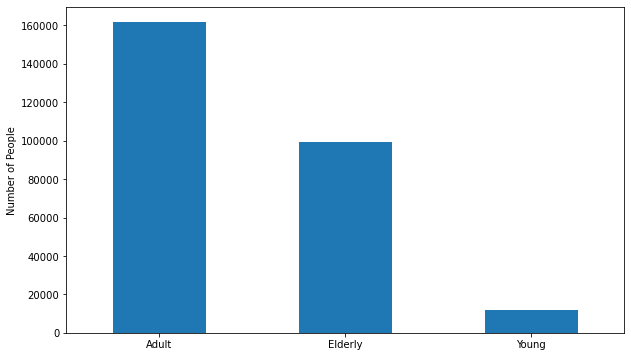

In [58]:
#plot the age
df["age"].value_counts().plot(kind='bar', rot=0, figsize=(10,6))
plt.ylabel('Number of People')

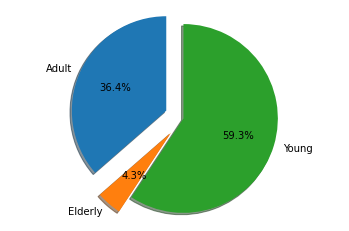

In [59]:
#plot pie chart the age
labels=['Adult','Elderly',"Young"]
valores=df["age"].value_counts()
values=[valores[1],  valores[2],valores[0]]
explode=(0.20,0.20,0)

fig1, ax1 = plt.subplots()
ax1.pie(values,explode,labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

So you can see that most of our customers are adults with 60%, then follow the elderly with 36% and finally the young people with 4.3%, which means that we are losing many young customers, which should call attention to try to attract more young customers.

### 4. What kind of offers are most used depending on the gender?
<a id="gender"></a>

Now instead of analyzing the age, we will analyze the gender of our customers but seeing what type of offer uses more each gender, so we can decide if it is better to send each offer depending on the gender.

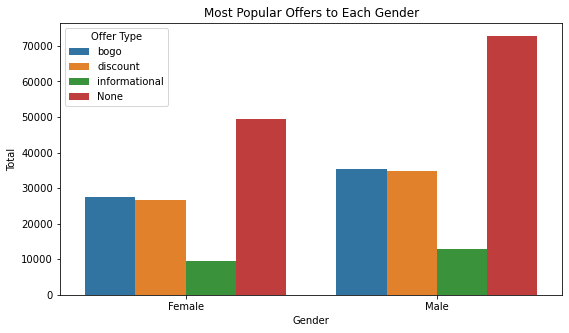

In [60]:
#plot offer type depend of gender
plt.figure(figsize=(9, 5))
g = sns.countplot(x='gender', hue="offer_type", data= df[df["gender"]!="O"])
plt.title('Most Popular Offers to Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
g.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show()

As can be seen from the independent, the same number of offers are made to the male gender as to the male. Therefore, no changes should be made to improve the reception of these offers.  
The only thing is that if we notice that there is an increase in men not using any offers compared to women.

### 5. What is the most frequent income range of customers?
<a id="income"></a>

Text(0, 0.5, 'Number of People')

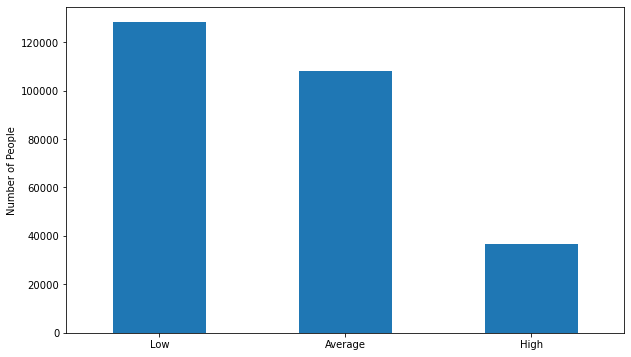

In [61]:
#plot income
df["income"].value_counts().plot(kind='bar', rot=0, figsize=(10,6))
plt.ylabel('Number of People')

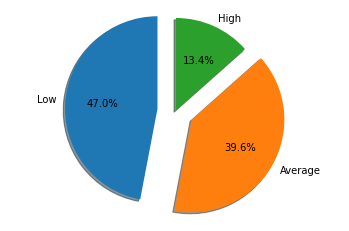

In [62]:
#plot pie chart income
labels=['Low','Average',"High"]
valores=df["income"].value_counts()
values=[valores[0],  valores[1],valores[2]]
explode=(0.20,0.20,0)

fig1, ax1 = plt.subplots()
ax1.pie(values,explode,labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

So we are seeing our customers are concentrated in a low or medium income level while those with a high income level do not provide us with purchases, so we should see the case where these customers do not feel comfortable in making purchases and thus be able to improve the sales ratio in high income customers.

## Model Data
<a id="model"></a>

Before we proceed to create the model and name the metrics that will be used to know the efficiency of our model, we will proceed with some changes in the dataset to be able to proceed with the creation of the model in an efficient and clean way.  
First we will perform a One Hot Encoding, to transform the category values into binary values to be processed well in the predictive model and not affect these values in the weights of the model.  
Then I will normalize the numerical values which are : days_inscription, duration and difficulty. 

In [63]:
#Dummys of category data and put label
df["Y"]=df["event"].map(lambda x: 1 if x=="completed" else 0)
df.drop(['event'],axis=1, inplace=True)
columns_dummys=["income","gender","offer_type","age"]
for dummy in columns_dummys:
    df = pd.concat([df,pd.get_dummies(df[dummy], prefix=dummy)],axis=1)
    df.drop([dummy],axis=1, inplace=True)
df.head()

,days_inscription,duration,difficulty,Y,income_Low,income_Average,income_High,gender_F,gender_M,gender_O,offer_type_None,offer_type_bogo,offer_type_discount,offer_type_informational,age_Young,age_Adult,age_Elderly
0,443.0,7.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
1,91.0,7.0,10.0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,167.0,5.0,5.0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,257.0,4.0,0.0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
4,318.0,10.0,20.0,0,1,0,0,1,0,0,0,0,1,0,0,0,1


In [64]:
#Normalize numeric data
scaler = MinMaxScaler()
features = ["days_inscription", "duration","difficulty"]
df[features] = scaler.fit_transform(df[features])
df.head()

,days_inscription,duration,difficulty,Y,income_Low,income_Average,income_High,gender_F,gender_M,gender_O,offer_type_None,offer_type_bogo,offer_type_discount,offer_type_informational,age_Young,age_Adult,age_Elderly
0,0.243006,0.7,0.25,0,0,0,1,1,0,0,0,1,0,0,0,0,1
1,0.049918,0.7,0.50,0,0,1,0,0,1,0,0,0,1,0,0,0,1
2,0.091607,0.5,0.25,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,0.140976,0.4,0.00,0,1,0,0,0,1,0,0,0,0,1,0,1,0
4,0.174438,1.0,1.00,0,1,0,0,1,0,0,0,0,1,0,0,0,1


In [65]:
#Split train and test data
train, test = train_test_split(df, test_size = 0.33, random_state=42)

### Unbalanced
<a id="unbalanced"></a>

We will choose to analyse whether the dataset is unbalanced, that is to say that we have most of the dataset of a class. This will produce bad results in our model because it has few examples to learn from the class we want to predict and it will over-adjust to the majority class, so I will analyse whether we have this case.

In [66]:
train["Y"].value_counts()

0    160918
1     21832
Name: Y, dtype: int64

In [67]:
train["Y"].value_counts()/train.shape[0]

0    0.880536
1    0.119464
Name: Y, dtype: float64

As can be seen, the dataset we have is unbalanced, i.e. we have 88% of the class 0 dataset, i.e. not completed, and we only have the remaining 12% of class 1, which we want to predict.  
To do this, I am going to replicate cases from class 1 until we have 40,000 examples, and I am going to eliminate examples from class 0 until we have 40,000 equally.  
In this way we will finally have a completely balanced dataset.

In [68]:
# Upsample minority class
df_minority=train[train["Y"]==1]
df_majority=train[train["Y"]==0]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=40000,    # to match majority class
                                 random_state=123)
# Downsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=40000,    # to match majority class
                                 random_state=123)
train= pd.concat([df_minority_upsampled, df_majority_downsampled])

In [69]:
train["Y"].value_counts()

1    40000
0    40000
Name: Y, dtype: int64

Now that the dataset is clean and standardised I will define the metrics.   
Metrices  
In order to evaluate our model performance we are using the accuracy, matriz de confusion y con ella obtendremos el F1-Score y la curva ROC.  

We are using the simple classification problem, el cual la etiqueta sera binaria {0,1}, en funcion si el evento ha sido completado o no.  
 
To know how our model is performing we will compare our model usando las metricas que he mencionado anteriormente.
* **Accuracy** : It is the probability of success in predicting the label.
* **F1-Score** : It is calculated from the precision and recall of the test.
* **Curva ROC**  : It is the area of the roc curve, which is the graph that sets the sensitivity to the specificity

To begin with, the dataset will be divided into two parts:
* Training : training dataset of the model.
* Test : final dataset with which we will obtain results of the metrics as if it was an external case.

I separate the datasets into label and input, and then pass them to the prediction models for training.

In [70]:
#Separate label and data
y_train=train["Y"]
X_train=train.drop(["Y"],axis=1)
X_test=test.drop(["Y"],axis=1)
y_test=test["Y"]

### Models
<a id="models"></a>

I will create 4 models with different configurations and different predictive models and evaluate them and then take the best one.
To do this, I will create a function called evaluate, which will pass the training and testing dataset, along with the model and possible hyperparameters to be tested from that model.
Then we will create a search for the model with the best hyperparameters, and from this best model we will predict with the test dataset and obtain the value of the metrics that have been mentioned above.
* Accuracy
* F1-Score
* Curva ROC  


In [71]:
accuracy=[]
f1=[]
auc=[]

def evaluate(X_train,X_test,Y_train,Y_test,parameters,model):
    '''
    INPUT:  
    X_train - (dataframe) Data training model
    X_test - (dataframe) Data test model
    Y_train - (series) label training model
    Y_test - (series) label test model
    parameters - parameters of model
    model - model that we want train

    OUTPUT: 
    clf - trained model
    accurracy - Accuracy of the model
    f1 - f1 of the model
    auc - auc of the model
    
    Train a given model according to possible hyperparameters and obtain its evaluation metrics
    
    '''
    clf = GridSearchCV(model,param_grid=parameters)
    clf.fit(X_train,Y_train)
    y_pred=clf.predict(X_test)
    accurracy=accuracy_score(y_test, y_pred)*100
    f1=f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot([0, 1], [0, 1], 'k--')
    auc = roc_auc_score(y_test, y_pred)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    print("Accuracy : {} , F1 : {}".format(accurracy,f1))
    return clf,accurracy,f1,auc

#### RandomForestClassifier
<a id="forest"></a>

Random Forest is a classification algorithm that is formed by a set of decision trees. This algorithm to generate each tree uses bagging and chooses the characteristics in a random way, what it does is to create a set of uncorrelated trees, which will allow us to obtain more success than a simple tree.

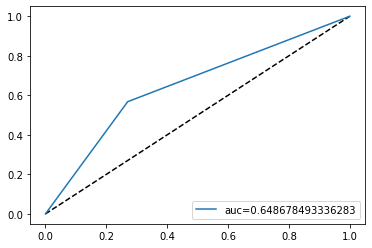

Accuracy : 71.05941430031551 , F1 : 0.31623707281222113


In [72]:
#Training RandomForestClassifier
parameters = {
        'n_estimators': [3,5, 15],
        'max_features' : ["sqrt", "log2"]
    }
clf_forest = RandomForestClassifier(random_state=42)
clf_forest,accurracy_forest,f1_forest,auc_forest=evaluate(X_train,X_test,y_train,y_test,parameters,clf_forest)
accuracy.append(accurracy_forest)
f1.append(f1_forest)
auc.append(auc_forest)

Using this algorithm I have obtained the following results:  
* Accuracy : 71.65 %
* F1 : 0.7105
* AUC : 0.3162

#### SVM
<a id="svn"></a>

SVM is a model that represents the sample points in space, separating the classes into 2 spaces as wide as possible by means of a separation hyperplane (support vector) defined as the separator between the 2 classes. When we are in the training phase and the new samples do not correspond to this model, this hyperplane is changed to be able to adjust to the new points.

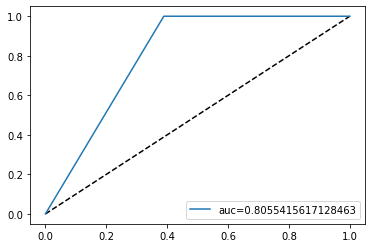

Accuracy : 65.69346309380971 , F1 : 0.4073391678182097


In [73]:
#Training SVM
parameters = {
        'kernel': ["linear", "poly", "rbf"],
    }
clf_svc = svm.SVC(random_state=42,class_weight='balanced')
clf_svc,accurracy_svc,f1_svc,auc_svc=evaluate(X_train,X_test,y_train,y_test,parameters,clf_svc)
accuracy.append(accurracy_svc)
f1.append(f1_svc)
auc.append(auc_svc)

Using this algorithm I have obtained the following results:  
* Accuracy : 65.69 %
* F1 : 0.4073
* AUC : 0.8055

#### KNN
<a id="knn"></a>

It is a non-parametric classification method, which is in charge of classifying the test values, taking one by one these values and looking for the k closest to this point and depending on its classes, it will be classified as the majority class.

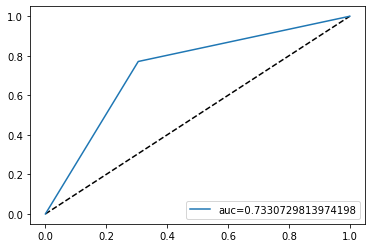

Accuracy : 70.40061325156645 , F1 : 0.38052500639401055


In [74]:
#Training KNN
parameters = {
        'algorithm': ["ball_tree", "kd_tree"],
        'n_neighbors' : [3,5,10]
    }
clf_knn = KNeighborsClassifier()
clf_knn,accurracy_knn,f1_knn,auc_knn=evaluate(X_train,X_test,y_train,y_test,parameters,clf_knn)
accuracy.append(accurracy_knn)
f1.append(f1_knn)
auc.append(auc_knn)

Using this algorithm I have obtained the following results:  
* Accuracy : 70.4 %
* F1 : 0.3805
* AUC : 0.733

#### Logistic Regression
<a id="logistic"></a>

Logistic regression is a type of regression analysis used to predict the outcome of a categorical variable based on the probability of the class occurring or not.

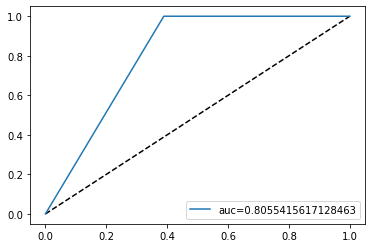

Accuracy : 65.69346309380971 , F1 : 0.4073391678182097


In [75]:
#Training Logistic Regression
parameters = {
        'solver': ["newton-cg", "sag"]
    }
clf_log = LogisticRegression(random_state=42)
clf_log,accurracy_log,f1_log,auc_log=evaluate(X_train,X_test,y_train,y_test,parameters,clf_log)
accuracy.append(accurracy_log)
f1.append(f1_log)
auc.append(auc_log)

Using this algorithm I have obtained the following results:  
* Accuracy : 65.69 %
* F1 : 0.4073 
* AUC : 0.8055 

## Results
<a id="summary"></a>

Now you will gather all the results obtained from each predictive model and choose the best model that will be used to predict whether a user will complete an offer or not.

In [76]:
#Summary of results
results = [accuracy, f1,auc]
models_re=["RandomForestClassifier","SVM","KNN","Logistic Regression"]

df_results = pd.DataFrame(results, columns = models_re, index=['Accuracy', 'F1','AUC'])
df_results

,RandomForestClassifier,SVM,KNN,Logistic Regression
Accuracy,71.059414,65.693463,70.400613,65.693463
F1,0.316237,0.407339,0.380525,0.407339
AUC,0.648678,0.805542,0.733073,0.805542


As you can see we have a tie between the logistic regression algorithm and the SVM, therefore, I will choose the SVM, in the case that we have the hyperparameter that works with unbalanced data and has a better behaviour.
Therefore, finally we will use the SVM model to predict whether a customer will complete an offer or not.

In [81]:
clf_svc.best_estimator_

SVC(class_weight='balanced', kernel='linear', random_state=42)

## Conclusion
<a id="conclusion"></a>

In conclusion this dataset has taught me the whole process of data science such as dataset loading, data pre-processing, features engineering, EDA, model creation and comparisons.  
In general, in this dataset I have followed the steps of data preprocessing to clean, noise remove and normalize the data. I also balanced the dataset to be good for the predictive models and then to be able to make a comparison with different predictive models, in which the best one has been the SVM model.  
In addition to this, we have answered a few questions in relation to the dataset, in the EDA section, which have been the following:  
* **1. Which event has been carried out more frequently?**  

As we saw the most likely event is the transaction, it is said that our customers prefer not to use the offers or such not very famous offers, so we should make these offers more affordable.
* **2. Which offer is the most popular?**  

The most complete offer is the discount offer even if more Bogo offers are sent, although the difference between their use was 6% which was not much, so from this question I do not see any change in this affordable to improve these results.
* **3. What is the most frequent age of our clients?**  

The majority of our clients are adults and then followed by the elderly and finally the young people, which means that we are losing many young clients, which should draw attention, to make some kind of offer for young people could be studied.
* **4. What kind of offers are most used depending on the gender?**  

It is independent, i.e. the female and the male gender receive the same number of offers. Therefore, no changes should be made to improve the reception of these offers.
* **5. What is the most frequent income range of customers?** 

Clients are concentrated in a low or medium income range while those with a high income range are not, so we should see the case where these clients do not feel comfortable to be our clients and thus be able to improve the sales ratio in clients with a high income range.


With this model Starbucks will be able to predict which customer will complete an offer based on their characteristics, and thus not send offers to people who will not complete such an offer, This model is an SVM algorithm, which has as a hyper parameter to balance the classes and also has obtained a 0.40 of F1 score and a 0.805 of AUC.  

Finally, all the process I have done can be improved and what I would improve would be the study of the chosen model and improve its parameters to obtain better results or so to say improve the pre-processing of the data and so be able to obtain better results giving more quality to the data, like for example improve the class balancing.

## Apprenticeship
<a id="apprenticeship"></a>

Thanks to this project I have learned the whole process that has to be done from the definition of the project to the creation of the model and the resolution of the problem that I have to solve.
In addition I have worked with real case, with a high percentage of work in data cleaning and its consequences. And also to have found an unbalanced problem and to have been able to improve results from balancing the classes.